Pewien słuchacz szkoły muzycznej ma w sobie niesamowity talent. Jednak przed jej ukończeniem wstrzymuje go jeden przedmiot - "Kompozytorzy muzyki klasycznej". Słuchacz ten, mając dość niepowodzeń w zdawaniu tego tematu, zwraca się do Was o pomoc.

Zadanie polega na stworzeniu modelu rekurencyjnego, który będzie przewidywał kompozytora danego utworu klasycznego w oparciu o jego zapis w formie sekwencji akordów. Akordy znormalizowane zostały do klucza C-dur lub a-moll, w zależności od skali utworu (durowa/molowa).
Dane przygotowane są w postaci pickle (https://docs.python.org/3/library/pickle.html), w których znajduje się lista krotek z sekwencjami i odpowiadającymi im klasami (kompozytorami), odpowiednio: {0: 'bach', 1: 'beethoven', 2: 'debussy', 3: 'scarlatti', 4: 'victoria'}. Dane treningowe znajdują się w pliku train.pkl. W pliku test_no_target.pkl znajdują się testowe sekwencje, dla których predykcje mają Państwo przewidzieć.

Uwaga, utwory mogą mieć różne długości. Do stworzenia batchy dla przykładów różnej długości proszę wykorzystać omówiony na zajęciach padding i trenować z wykorzystaniem wyrównanych tensorów lub spakowanych sekwencji (PackedSequence).

Bardzo proszę, żeby zwrócili Państwo archiwum zip, zgodnie z instrukcjami:
- Archiwum powinno być nazwane {poniedzialek/piatek}_nazwisko1_nazwisko2.zip, bez nawiasów klamrowych przy dniu tygodnia
- W archiwum proszę, bez zbędnych podfolderów, umieścić pliki ze swoim kodem i testowe predykcje nazwane {poniedzialek/piatek}_nazwisko1_nazwisko2.csv (lub nazwa drużyny), bez nawiasów klamrowych przy dniu tygodnia
- Testowe predykcje powinny mieć kolejność zgodną z kolejnością sekwencji w picklu. Plik .csv nie powinien mieć nagłówka ani indeksów.

Proszę zwracać uwagę na prawidłowe nazewnictwo oraz odpowiedni format zwracanych plików. Niedostosowanie się do wytycznych może spowodować nieuwzględnienie Państwa w rankingu i utratę punktów za osiągnięty wynik!
Proszę także o udokumentowanie wykonanych eksperymentów.

In [1]:
import pickle
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torch.functional import F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = './data'
MODEL_PATH = './models'

BATCH_SIZE = 32
LEARNING_RATE = 0.001
TEST_RATIO = 0.2
EPOCHS = 101

MAX_DATASET_LEN = 750

HIDDEN_DIM = 128
INPUT_DIM = 1
OUTPUT_DIM = 5
DROPOUT_RATE = 0.5

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda


In [4]:
with open(f'{DATA_PATH}/train.pkl', 'rb') as file:
    train_data = pickle.load(file)

with open(f'{DATA_PATH}/test_no_target.pkl', 'rb') as file:
    test_data = pickle.load(file)


In [5]:
class MusicDataset(Dataset):
    def __init__(self, data, max_len=None, is_train_dataset=True):
        if is_train_dataset:
            self.seq, self.labels = zip(*data)
        else:
            self.seq = data
            self.labels = [None] * len(data) 
            
        self.max_len = max(len(s) for s in self.seq)
        self.seq = [MusicDataset.pad_collate(self, seq) for seq in self.seq]
        self.is_train_dataset = is_train_dataset
    
    def __len__(self):
        return len(self.seq)
    
    def __getitem__(self, idx):
        return self.seq[idx], self.labels[idx] if self.is_train_dataset else self.seq[idx]

    @staticmethod
    def pad_collate(self, seq, pad_value=0):
        seq = torch.tensor(seq, dtype=torch.float32).unsqueeze(1)
        padding = self.max_len - len(seq)
        return F.pad(seq, (0, 0, 0, padding), mode="constant", value=pad_value)


In [6]:
train_data, validation_data = train_test_split(train_data, test_size=TEST_RATIO)

train_dataset = MusicDataset(train_data, max_len=MAX_DATASET_LEN, is_train_dataset=True)
test_dataset = MusicDataset(test_data, max_len=MAX_DATASET_LEN, is_train_dataset=False)
validation_dataset = MusicDataset(validation_data, max_len=MAX_DATASET_LEN, is_train_dataset=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
class ComposerClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers=1):
        super(ComposerClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, 
                            hidden_dim, 
                            num_layers=n_layers, 
                            bidirectional=True, 
                            batch_first=True,
                            dropout=DROPOUT_RATE)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(DROPOUT_RATE)
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)
    
    def forward(self, x):
        lstm_out, (hidden, cell) = self.lstm(x)
        x = torch.cat((hidden[-2], hidden[-1]), dim=1)
        x = self.batch_norm(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [8]:
_, train_labels = zip(*train_data)
class_nums = Counter(train_labels)
samples_num = sum(class_nums.values())
class_weights = {cls: samples_num / num for cls, num in class_nums.items()}
weights = torch.tensor([class_weights[ii] for ii in range(len(class_nums))], dtype=torch.float32).to(device)

In [9]:
model = ComposerClassifier(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

/home/karol/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/karol/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
best_validation_loss = float('inf')
best_validation_accuracy = 0.0
early_stop_num = 0
early_stop_threshold = 5
train_loss = []
train_accuracy = []
validation_loss = []
validation_accuracy = []

for epoch in tqdm(range(EPOCHS)):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    for sequences, labels in train_loader:
        sequences = sequences.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

        outputs = outputs.cpu()
        labels = labels.cpu()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_accuracy.append(correct / total)
    train_loss.append(total_loss / len(train_loader))

    print(f'Epoch {epoch + 1}/{EPOCHS} - Train Loss: {train_loss[-1]:.4f} - Train Accuracy: {train_accuracy[-1]:.4f}')

    model.eval()
    validation_loss_epoch = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for sequences, labels in validation_loader:
            sequences = sequences.to(device)
            labels = labels.to(device)

            outputs = model(sequences)
            loss = criterion(outputs, labels)

            validation_loss_epoch += loss.item()

            outputs = outputs.cpu()
            labels = labels.cpu()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    validation_accuracy_epoch = correct / total
    validation_accuracy.append(validation_accuracy_epoch)
    validation_loss.append(validation_loss_epoch / len(validation_loader))
    average_validation_loss = validation_loss_epoch / len(validation_loader)

    print(f'Epoch {epoch + 1}/{EPOCHS} - Validation Loss: {average_validation_loss:.4f} - Validation Accuracy: {validation_accuracy_epoch:.4f}')
    
    if validation_accuracy_epoch > best_validation_accuracy:
        best_validation_accuracy = validation_accuracy_epoch
        torch.save(model.state_dict(), f'{MODEL_PATH}/best.pth')
    
print('Best accuracy:', best_validation_accuracy)

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch 1/101 - Train Loss: 1.4296 - Train Accuracy: 0.4049


  1%|          | 1/101 [00:07<12:00,  7.21s/it]

Epoch 1/101 - Validation Loss: 1.1641 - Validation Accuracy: 0.6088
Epoch 2/101 - Train Loss: 1.1648 - Train Accuracy: 0.5700


  2%|▏         | 2/101 [00:14<11:44,  7.11s/it]

Epoch 2/101 - Validation Loss: 1.1809 - Validation Accuracy: 0.6156
Epoch 3/101 - Train Loss: 1.1014 - Train Accuracy: 0.5853


  3%|▎         | 3/101 [00:21<11:34,  7.09s/it]

Epoch 3/101 - Validation Loss: 1.2373 - Validation Accuracy: 0.6344
Epoch 4/101 - Train Loss: 1.0596 - Train Accuracy: 0.5866


  4%|▍         | 4/101 [00:28<11:25,  7.07s/it]

Epoch 4/101 - Validation Loss: 1.2769 - Validation Accuracy: 0.6122
Epoch 5/101 - Train Loss: 1.0089 - Train Accuracy: 0.6185


  5%|▍         | 5/101 [00:35<11:18,  7.06s/it]

Epoch 5/101 - Validation Loss: 1.2583 - Validation Accuracy: 0.6480
Epoch 6/101 - Train Loss: 1.0042 - Train Accuracy: 0.6270


  6%|▌         | 6/101 [00:42<11:12,  7.08s/it]

Epoch 6/101 - Validation Loss: 1.8645 - Validation Accuracy: 0.5884
Epoch 7/101 - Train Loss: 0.9694 - Train Accuracy: 0.6393


  7%|▋         | 7/101 [00:49<11:05,  7.08s/it]

Epoch 7/101 - Validation Loss: 1.0809 - Validation Accuracy: 0.6735
Epoch 8/101 - Train Loss: 0.9876 - Train Accuracy: 0.6368


  8%|▊         | 8/101 [00:56<10:58,  7.08s/it]

Epoch 8/101 - Validation Loss: 1.1839 - Validation Accuracy: 0.6854
Epoch 9/101 - Train Loss: 0.9331 - Train Accuracy: 0.6474


  9%|▉         | 9/101 [01:03<10:50,  7.08s/it]

Epoch 9/101 - Validation Loss: 1.3932 - Validation Accuracy: 0.6276
Epoch 10/101 - Train Loss: 0.9127 - Train Accuracy: 0.6542


 10%|▉         | 10/101 [01:10<10:43,  7.07s/it]

Epoch 10/101 - Validation Loss: 2.5771 - Validation Accuracy: 0.2330
Epoch 11/101 - Train Loss: 0.8739 - Train Accuracy: 0.6874


 11%|█         | 11/101 [01:17<10:37,  7.08s/it]

Epoch 11/101 - Validation Loss: 0.9981 - Validation Accuracy: 0.6837
Epoch 12/101 - Train Loss: 0.8425 - Train Accuracy: 0.6908


 12%|█▏        | 12/101 [01:25<10:31,  7.09s/it]

Epoch 12/101 - Validation Loss: 1.0673 - Validation Accuracy: 0.6667
Epoch 13/101 - Train Loss: 0.8580 - Train Accuracy: 0.6869


 13%|█▎        | 13/101 [01:32<10:23,  7.09s/it]

Epoch 13/101 - Validation Loss: 0.9945 - Validation Accuracy: 0.6990
Epoch 14/101 - Train Loss: 0.8546 - Train Accuracy: 0.6916


 14%|█▍        | 14/101 [01:39<10:17,  7.09s/it]

Epoch 14/101 - Validation Loss: 0.9580 - Validation Accuracy: 0.7194
Epoch 15/101 - Train Loss: 0.7738 - Train Accuracy: 0.7129


 15%|█▍        | 15/101 [01:46<10:10,  7.10s/it]

Epoch 15/101 - Validation Loss: 0.9705 - Validation Accuracy: 0.6888
Epoch 16/101 - Train Loss: 0.8035 - Train Accuracy: 0.7082


 16%|█▌        | 16/101 [01:53<10:02,  7.09s/it]

Epoch 16/101 - Validation Loss: 1.0313 - Validation Accuracy: 0.6922
Epoch 17/101 - Train Loss: 0.7786 - Train Accuracy: 0.7210


 17%|█▋        | 17/101 [02:00<09:54,  7.08s/it]

Epoch 17/101 - Validation Loss: 0.9118 - Validation Accuracy: 0.7483
Epoch 18/101 - Train Loss: 0.7393 - Train Accuracy: 0.7269


 18%|█▊        | 18/101 [02:07<09:47,  7.08s/it]

Epoch 18/101 - Validation Loss: 0.9432 - Validation Accuracy: 0.7347
Epoch 19/101 - Train Loss: 0.7189 - Train Accuracy: 0.7435


 19%|█▉        | 19/101 [02:14<09:40,  7.07s/it]

Epoch 19/101 - Validation Loss: 1.0047 - Validation Accuracy: 0.7347
Epoch 20/101 - Train Loss: 0.7468 - Train Accuracy: 0.7201


 20%|█▉        | 20/101 [02:21<09:33,  7.08s/it]

Epoch 20/101 - Validation Loss: 0.9226 - Validation Accuracy: 0.7160
Epoch 21/101 - Train Loss: 0.6856 - Train Accuracy: 0.7507


 21%|██        | 21/101 [02:28<09:26,  7.09s/it]

Epoch 21/101 - Validation Loss: 0.8882 - Validation Accuracy: 0.7177
Epoch 22/101 - Train Loss: 0.6702 - Train Accuracy: 0.7558


 22%|██▏       | 22/101 [02:35<09:19,  7.09s/it]

Epoch 22/101 - Validation Loss: 0.8634 - Validation Accuracy: 0.7483
Epoch 23/101 - Train Loss: 0.6581 - Train Accuracy: 0.7750


 23%|██▎       | 23/101 [02:42<09:12,  7.09s/it]

Epoch 23/101 - Validation Loss: 0.8689 - Validation Accuracy: 0.7432
Epoch 24/101 - Train Loss: 0.6310 - Train Accuracy: 0.7724


 24%|██▍       | 24/101 [02:50<09:05,  7.08s/it]

Epoch 24/101 - Validation Loss: 0.9186 - Validation Accuracy: 0.7483
Epoch 25/101 - Train Loss: 0.6338 - Train Accuracy: 0.7809


 25%|██▍       | 25/101 [02:57<08:58,  7.09s/it]

Epoch 25/101 - Validation Loss: 0.9337 - Validation Accuracy: 0.7636
Epoch 26/101 - Train Loss: 0.6191 - Train Accuracy: 0.7831


 26%|██▌       | 26/101 [03:04<08:52,  7.10s/it]

Epoch 26/101 - Validation Loss: 0.8739 - Validation Accuracy: 0.7398
Epoch 27/101 - Train Loss: 0.6016 - Train Accuracy: 0.7839


 27%|██▋       | 27/101 [03:11<08:44,  7.09s/it]

Epoch 27/101 - Validation Loss: 0.9421 - Validation Accuracy: 0.7177
Epoch 28/101 - Train Loss: 0.6099 - Train Accuracy: 0.7912


 28%|██▊       | 28/101 [03:18<08:37,  7.09s/it]

Epoch 28/101 - Validation Loss: 0.8624 - Validation Accuracy: 0.7636
Epoch 29/101 - Train Loss: 0.6040 - Train Accuracy: 0.7890


 29%|██▊       | 29/101 [03:25<08:30,  7.09s/it]

Epoch 29/101 - Validation Loss: 0.9285 - Validation Accuracy: 0.7194
Epoch 30/101 - Train Loss: 0.5570 - Train Accuracy: 0.8069


 30%|██▉       | 30/101 [03:32<08:23,  7.09s/it]

Epoch 30/101 - Validation Loss: 1.0608 - Validation Accuracy: 0.6616
Epoch 31/101 - Train Loss: 0.5886 - Train Accuracy: 0.7903


 31%|███       | 31/101 [03:39<08:16,  7.09s/it]

Epoch 31/101 - Validation Loss: 0.8050 - Validation Accuracy: 0.7398
Epoch 32/101 - Train Loss: 0.5681 - Train Accuracy: 0.8043


 32%|███▏      | 32/101 [03:46<08:09,  7.10s/it]

Epoch 32/101 - Validation Loss: 0.8231 - Validation Accuracy: 0.7500
Epoch 33/101 - Train Loss: 0.5173 - Train Accuracy: 0.8192


 33%|███▎      | 33/101 [03:53<08:02,  7.10s/it]

Epoch 33/101 - Validation Loss: 0.7924 - Validation Accuracy: 0.7653
Epoch 34/101 - Train Loss: 0.5337 - Train Accuracy: 0.8133


 34%|███▎      | 34/101 [04:01<07:55,  7.10s/it]

Epoch 34/101 - Validation Loss: 0.7862 - Validation Accuracy: 0.7568
Epoch 35/101 - Train Loss: 0.4943 - Train Accuracy: 0.8282


 35%|███▍      | 35/101 [04:08<07:48,  7.11s/it]

Epoch 35/101 - Validation Loss: 0.7707 - Validation Accuracy: 0.7738
Epoch 36/101 - Train Loss: 0.4952 - Train Accuracy: 0.8222


 36%|███▌      | 36/101 [04:15<07:41,  7.10s/it]

Epoch 36/101 - Validation Loss: 0.8163 - Validation Accuracy: 0.7755
Epoch 37/101 - Train Loss: 0.4764 - Train Accuracy: 0.8354


 37%|███▋      | 37/101 [04:22<07:34,  7.10s/it]

Epoch 37/101 - Validation Loss: 1.1066 - Validation Accuracy: 0.7789
Epoch 38/101 - Train Loss: 0.4482 - Train Accuracy: 0.8494


 38%|███▊      | 38/101 [04:29<07:27,  7.10s/it]

Epoch 38/101 - Validation Loss: 1.2613 - Validation Accuracy: 0.7687
Epoch 39/101 - Train Loss: 0.6295 - Train Accuracy: 0.7763


 39%|███▊      | 39/101 [04:36<07:19,  7.09s/it]

Epoch 39/101 - Validation Loss: 0.9922 - Validation Accuracy: 0.6888
Epoch 40/101 - Train Loss: 0.5791 - Train Accuracy: 0.7963


 40%|███▉      | 40/101 [04:43<07:12,  7.08s/it]

Epoch 40/101 - Validation Loss: 0.7643 - Validation Accuracy: 0.7534
Epoch 41/101 - Train Loss: 0.5206 - Train Accuracy: 0.8188


 41%|████      | 41/101 [04:50<07:05,  7.08s/it]

Epoch 41/101 - Validation Loss: 0.8827 - Validation Accuracy: 0.7687
Epoch 42/101 - Train Loss: 0.4797 - Train Accuracy: 0.8316


 42%|████▏     | 42/101 [04:57<06:59,  7.11s/it]

Epoch 42/101 - Validation Loss: 0.8720 - Validation Accuracy: 0.7653
Epoch 43/101 - Train Loss: 0.4465 - Train Accuracy: 0.8494


 43%|████▎     | 43/101 [05:04<06:52,  7.12s/it]

Epoch 43/101 - Validation Loss: 0.9059 - Validation Accuracy: 0.7704
Epoch 44/101 - Train Loss: 0.4694 - Train Accuracy: 0.8422


 44%|████▎     | 44/101 [05:12<06:45,  7.11s/it]

Epoch 44/101 - Validation Loss: 0.9990 - Validation Accuracy: 0.7449
Epoch 45/101 - Train Loss: 0.4427 - Train Accuracy: 0.8469


 45%|████▍     | 45/101 [05:19<06:38,  7.11s/it]

Epoch 45/101 - Validation Loss: 1.1579 - Validation Accuracy: 0.6531
Epoch 46/101 - Train Loss: 0.4232 - Train Accuracy: 0.8541


 46%|████▌     | 46/101 [05:26<06:31,  7.12s/it]

Epoch 46/101 - Validation Loss: 0.8382 - Validation Accuracy: 0.7636
Epoch 47/101 - Train Loss: 0.3831 - Train Accuracy: 0.8694


 47%|████▋     | 47/101 [05:33<06:24,  7.12s/it]

Epoch 47/101 - Validation Loss: 0.8703 - Validation Accuracy: 0.7772
Epoch 48/101 - Train Loss: 0.3781 - Train Accuracy: 0.8652


 48%|████▊     | 48/101 [05:40<06:17,  7.13s/it]

Epoch 48/101 - Validation Loss: 0.9182 - Validation Accuracy: 0.7602
Epoch 49/101 - Train Loss: 0.3623 - Train Accuracy: 0.8724


 49%|████▊     | 49/101 [05:47<06:10,  7.12s/it]

Epoch 49/101 - Validation Loss: 0.9311 - Validation Accuracy: 0.7619
Epoch 50/101 - Train Loss: 0.3681 - Train Accuracy: 0.8788


 50%|████▉     | 50/101 [05:54<06:02,  7.11s/it]

Epoch 50/101 - Validation Loss: 0.8234 - Validation Accuracy: 0.7857
Epoch 51/101 - Train Loss: 0.3496 - Train Accuracy: 0.8805


 50%|█████     | 51/101 [06:01<05:55,  7.10s/it]

Epoch 51/101 - Validation Loss: 0.8938 - Validation Accuracy: 0.7704
Epoch 52/101 - Train Loss: 0.3390 - Train Accuracy: 0.8826


 51%|█████▏    | 52/101 [06:08<05:48,  7.10s/it]

Epoch 52/101 - Validation Loss: 0.8072 - Validation Accuracy: 0.8027
Epoch 53/101 - Train Loss: 0.3569 - Train Accuracy: 0.8749


 52%|█████▏    | 53/101 [06:15<05:40,  7.10s/it]

Epoch 53/101 - Validation Loss: 0.8494 - Validation Accuracy: 0.7806
Epoch 54/101 - Train Loss: 0.3575 - Train Accuracy: 0.8783


 53%|█████▎    | 54/101 [06:23<05:33,  7.09s/it]

Epoch 54/101 - Validation Loss: 0.8715 - Validation Accuracy: 0.7772
Epoch 55/101 - Train Loss: 0.3443 - Train Accuracy: 0.8779


 54%|█████▍    | 55/101 [06:30<05:26,  7.11s/it]

Epoch 55/101 - Validation Loss: 0.9919 - Validation Accuracy: 0.7772
Epoch 56/101 - Train Loss: 0.3096 - Train Accuracy: 0.8966


 55%|█████▌    | 56/101 [06:37<05:19,  7.11s/it]

Epoch 56/101 - Validation Loss: 1.0385 - Validation Accuracy: 0.7687
Epoch 57/101 - Train Loss: 0.3189 - Train Accuracy: 0.8932


 56%|█████▋    | 57/101 [06:44<05:12,  7.10s/it]

Epoch 57/101 - Validation Loss: 1.2715 - Validation Accuracy: 0.7126
Epoch 58/101 - Train Loss: 0.3072 - Train Accuracy: 0.8890


 57%|█████▋    | 58/101 [06:51<05:05,  7.10s/it]

Epoch 58/101 - Validation Loss: 1.0536 - Validation Accuracy: 0.7925
Epoch 59/101 - Train Loss: 0.2746 - Train Accuracy: 0.9047


 58%|█████▊    | 59/101 [06:58<04:57,  7.08s/it]

Epoch 59/101 - Validation Loss: 1.0736 - Validation Accuracy: 0.7925
Epoch 60/101 - Train Loss: 0.2860 - Train Accuracy: 0.9039


 59%|█████▉    | 60/101 [07:05<04:50,  7.09s/it]

Epoch 60/101 - Validation Loss: 1.1416 - Validation Accuracy: 0.7908
Epoch 61/101 - Train Loss: 0.2743 - Train Accuracy: 0.9141


 60%|██████    | 61/101 [07:12<04:43,  7.09s/it]

Epoch 61/101 - Validation Loss: 1.1168 - Validation Accuracy: 0.7721
Epoch 62/101 - Train Loss: 0.2739 - Train Accuracy: 0.9124


 61%|██████▏   | 62/101 [07:19<04:36,  7.09s/it]

Epoch 62/101 - Validation Loss: 1.1734 - Validation Accuracy: 0.7670
Epoch 63/101 - Train Loss: 0.2694 - Train Accuracy: 0.9047


 62%|██████▏   | 63/101 [07:26<04:29,  7.09s/it]

Epoch 63/101 - Validation Loss: 1.1750 - Validation Accuracy: 0.7857
Epoch 64/101 - Train Loss: 0.2715 - Train Accuracy: 0.9137


 63%|██████▎   | 64/101 [07:34<04:22,  7.09s/it]

Epoch 64/101 - Validation Loss: 1.1876 - Validation Accuracy: 0.7874
Epoch 65/101 - Train Loss: 0.2596 - Train Accuracy: 0.9081


 64%|██████▍   | 65/101 [07:41<04:14,  7.08s/it]

Epoch 65/101 - Validation Loss: 1.1226 - Validation Accuracy: 0.7806
Epoch 66/101 - Train Loss: 0.2537 - Train Accuracy: 0.9183


 65%|██████▌   | 66/101 [07:48<04:07,  7.07s/it]

Epoch 66/101 - Validation Loss: 1.1908 - Validation Accuracy: 0.7908
Epoch 67/101 - Train Loss: 0.2349 - Train Accuracy: 0.9166


 66%|██████▋   | 67/101 [07:55<04:00,  7.08s/it]

Epoch 67/101 - Validation Loss: 1.1660 - Validation Accuracy: 0.7772
Epoch 68/101 - Train Loss: 0.2414 - Train Accuracy: 0.9196


 67%|██████▋   | 68/101 [08:02<03:53,  7.08s/it]

Epoch 68/101 - Validation Loss: 1.1539 - Validation Accuracy: 0.7721
Epoch 69/101 - Train Loss: 0.2412 - Train Accuracy: 0.9188


 68%|██████▊   | 69/101 [08:09<03:46,  7.08s/it]

Epoch 69/101 - Validation Loss: 1.1861 - Validation Accuracy: 0.7806
Epoch 70/101 - Train Loss: 0.2263 - Train Accuracy: 0.9234


 69%|██████▉   | 70/101 [08:16<03:38,  7.06s/it]

Epoch 70/101 - Validation Loss: 1.1465 - Validation Accuracy: 0.7619
Epoch 71/101 - Train Loss: 0.2030 - Train Accuracy: 0.9290


 70%|███████   | 71/101 [08:23<03:32,  7.07s/it]

Epoch 71/101 - Validation Loss: 1.2135 - Validation Accuracy: 0.7857
Epoch 72/101 - Train Loss: 0.2280 - Train Accuracy: 0.9247


 71%|███████▏  | 72/101 [08:30<03:25,  7.07s/it]

Epoch 72/101 - Validation Loss: 1.1582 - Validation Accuracy: 0.7721
Epoch 73/101 - Train Loss: 0.2463 - Train Accuracy: 0.9145


 72%|███████▏  | 73/101 [08:37<03:18,  7.08s/it]

Epoch 73/101 - Validation Loss: 1.0477 - Validation Accuracy: 0.7942
Epoch 74/101 - Train Loss: 0.2160 - Train Accuracy: 0.9302


 73%|███████▎  | 74/101 [08:44<03:11,  7.08s/it]

Epoch 74/101 - Validation Loss: 1.0308 - Validation Accuracy: 0.7619
Epoch 75/101 - Train Loss: 0.2588 - Train Accuracy: 0.9120


 74%|███████▍  | 75/101 [08:51<03:04,  7.09s/it]

Epoch 75/101 - Validation Loss: 0.9712 - Validation Accuracy: 0.7755
Epoch 76/101 - Train Loss: 0.1883 - Train Accuracy: 0.9422


 75%|███████▌  | 76/101 [08:58<02:57,  7.09s/it]

Epoch 76/101 - Validation Loss: 1.2007 - Validation Accuracy: 0.7891
Epoch 77/101 - Train Loss: 0.1573 - Train Accuracy: 0.9473


 76%|███████▌  | 77/101 [09:06<02:50,  7.08s/it]

Epoch 77/101 - Validation Loss: 1.0205 - Validation Accuracy: 0.7908
Epoch 78/101 - Train Loss: 0.1571 - Train Accuracy: 0.9456


 77%|███████▋  | 78/101 [09:13<02:42,  7.07s/it]

Epoch 78/101 - Validation Loss: 1.0812 - Validation Accuracy: 0.7755
Epoch 79/101 - Train Loss: 0.1755 - Train Accuracy: 0.9379


 78%|███████▊  | 79/101 [09:20<02:35,  7.07s/it]

Epoch 79/101 - Validation Loss: 1.0608 - Validation Accuracy: 0.7823
Epoch 80/101 - Train Loss: 0.1617 - Train Accuracy: 0.9413


 79%|███████▉  | 80/101 [09:27<02:28,  7.07s/it]

Epoch 80/101 - Validation Loss: 1.4378 - Validation Accuracy: 0.7721
Epoch 81/101 - Train Loss: 0.2171 - Train Accuracy: 0.9285


 80%|████████  | 81/101 [09:34<02:21,  7.08s/it]

Epoch 81/101 - Validation Loss: 2.3116 - Validation Accuracy: 0.5374
Epoch 82/101 - Train Loss: 0.7513 - Train Accuracy: 0.7550


 81%|████████  | 82/101 [09:41<02:14,  7.08s/it]

Epoch 82/101 - Validation Loss: 1.0362 - Validation Accuracy: 0.7296
Epoch 83/101 - Train Loss: 0.5115 - Train Accuracy: 0.8231


 82%|████████▏ | 83/101 [09:48<02:07,  7.09s/it]

Epoch 83/101 - Validation Loss: 0.9931 - Validation Accuracy: 0.7347
Epoch 84/101 - Train Loss: 0.4692 - Train Accuracy: 0.8320


 83%|████████▎ | 84/101 [09:55<02:00,  7.09s/it]

Epoch 84/101 - Validation Loss: 1.0012 - Validation Accuracy: 0.7313
Epoch 85/101 - Train Loss: 0.4521 - Train Accuracy: 0.8499


 84%|████████▍ | 85/101 [10:02<01:53,  7.10s/it]

Epoch 85/101 - Validation Loss: 1.0342 - Validation Accuracy: 0.7534
Epoch 86/101 - Train Loss: 0.4131 - Train Accuracy: 0.8558


 85%|████████▌ | 86/101 [10:09<01:46,  7.11s/it]

Epoch 86/101 - Validation Loss: 1.2032 - Validation Accuracy: 0.7585
Epoch 87/101 - Train Loss: 0.4190 - Train Accuracy: 0.8464


 86%|████████▌ | 87/101 [10:17<01:39,  7.13s/it]

Epoch 87/101 - Validation Loss: 1.1917 - Validation Accuracy: 0.7500
Epoch 88/101 - Train Loss: 0.4513 - Train Accuracy: 0.8388


 87%|████████▋ | 88/101 [10:24<01:32,  7.13s/it]

Epoch 88/101 - Validation Loss: 1.1796 - Validation Accuracy: 0.7568
Epoch 89/101 - Train Loss: 0.4107 - Train Accuracy: 0.8579


 88%|████████▊ | 89/101 [10:31<01:25,  7.15s/it]

Epoch 89/101 - Validation Loss: 1.1305 - Validation Accuracy: 0.7687
Epoch 90/101 - Train Loss: 0.3698 - Train Accuracy: 0.8728


 89%|████████▉ | 90/101 [10:38<01:18,  7.16s/it]

Epoch 90/101 - Validation Loss: 1.1375 - Validation Accuracy: 0.7806
Epoch 91/101 - Train Loss: 0.3583 - Train Accuracy: 0.8758


 90%|█████████ | 91/101 [10:45<01:11,  7.16s/it]

Epoch 91/101 - Validation Loss: 1.0661 - Validation Accuracy: 0.7738
Epoch 92/101 - Train Loss: 0.3410 - Train Accuracy: 0.8796


 91%|█████████ | 92/101 [10:52<01:04,  7.16s/it]

Epoch 92/101 - Validation Loss: 1.1241 - Validation Accuracy: 0.7721
Epoch 93/101 - Train Loss: 0.3556 - Train Accuracy: 0.8754


 92%|█████████▏| 93/101 [11:00<00:57,  7.16s/it]

Epoch 93/101 - Validation Loss: 1.0632 - Validation Accuracy: 0.7653
Epoch 94/101 - Train Loss: 0.3255 - Train Accuracy: 0.8937


 93%|█████████▎| 94/101 [11:07<00:50,  7.16s/it]

Epoch 94/101 - Validation Loss: 1.0329 - Validation Accuracy: 0.7772
Epoch 95/101 - Train Loss: 0.5769 - Train Accuracy: 0.8026


 94%|█████████▍| 95/101 [11:14<00:42,  7.15s/it]

Epoch 95/101 - Validation Loss: 1.1150 - Validation Accuracy: 0.7279
Epoch 96/101 - Train Loss: 0.4028 - Train Accuracy: 0.8550


 95%|█████████▌| 96/101 [11:21<00:35,  7.15s/it]

Epoch 96/101 - Validation Loss: 1.0584 - Validation Accuracy: 0.7381
Epoch 97/101 - Train Loss: 0.3695 - Train Accuracy: 0.8711


 96%|█████████▌| 97/101 [11:28<00:28,  7.16s/it]

Epoch 97/101 - Validation Loss: 1.0282 - Validation Accuracy: 0.7432
Epoch 98/101 - Train Loss: 0.3650 - Train Accuracy: 0.8715


 97%|█████████▋| 98/101 [11:35<00:21,  7.16s/it]

Epoch 98/101 - Validation Loss: 0.9873 - Validation Accuracy: 0.7619
Epoch 99/101 - Train Loss: 0.3489 - Train Accuracy: 0.8801


 98%|█████████▊| 99/101 [11:42<00:14,  7.16s/it]

Epoch 99/101 - Validation Loss: 1.1236 - Validation Accuracy: 0.7143
Epoch 100/101 - Train Loss: 0.2901 - Train Accuracy: 0.9009


 99%|█████████▉| 100/101 [11:50<00:07,  7.16s/it]

Epoch 100/101 - Validation Loss: 1.0232 - Validation Accuracy: 0.7687
Epoch 101/101 - Train Loss: 0.2816 - Train Accuracy: 0.9034


100%|██████████| 101/101 [11:57<00:00,  7.10s/it]

Epoch 101/101 - Validation Loss: 1.0359 - Validation Accuracy: 0.7687
Best accuracy: 0.8027210884353742


In [10]:
model.load_state_dict(torch.load(f'{MODEL_PATH}/best.pth'))

predictions = []

with torch.no_grad():
    model.eval()
    
    for seq, labels in test_loader:
        seq = seq.to(device)
        outputs = model(seq)
        outputs = outputs.cpu()
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

df = pd.DataFrame(predictions)
df.to_csv('poniedzialek_kieruczenko_ziarek.csv', header=False, index=False)

In [12]:
epochs = range(1, EPOCHS + 1)

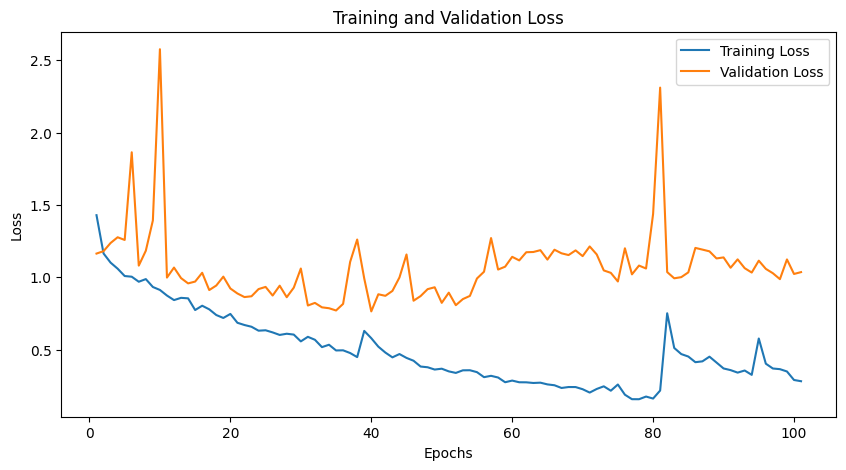

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

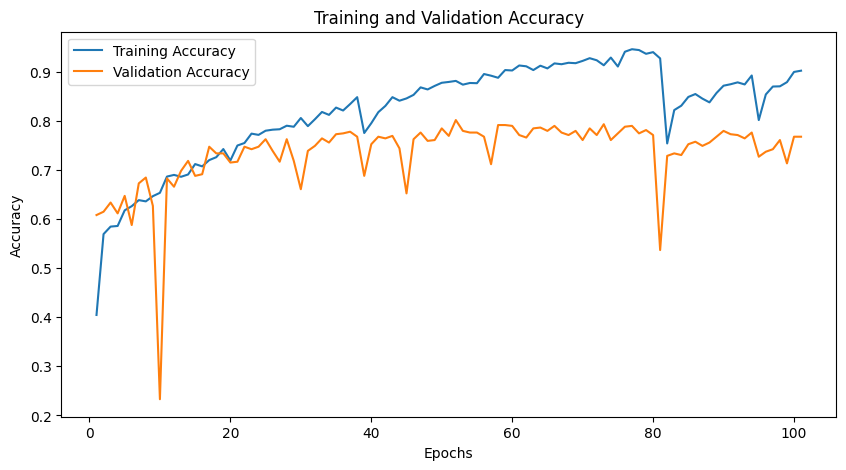

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()